In [73]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/processed/yp_competitors_rws_0001_0050_topics.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 24 columns):
lsi_topic_mode                            500 non-null int64
lsi_topic_mode_prob                       500 non-null object
lsi_topic_list                            500 non-null object
lsi_logentropy_topic_mode                 500 non-null int64
lsi_logentropy_topic_mode_prob            500 non-null object
lsi_logentropy_topic_list                 500 non-null object
lsi_tfidf_topic_mode                      500 non-null int64
lsi_tfidf_topic_mode_prob                 500 non-null object
lsi_tfidf_topic_list                      500 non-null object
lda_logentropy_topic_mode                 500 non-null int64
lda_logentropy_topic_mode_prob            500 non-null object
lda_logentropy_topic_list                 500 non-null object
lsi_random_projections_topic_mode         500 non-null int64
lsi_random_projections_topic_mode_prob    500 non-null object
lsi_random_projections_topic_lis

In [79]:
[i for i in df.columns if i.endswith('_mode')]

['lsi_topic_mode',
 'lsi_logentropy_topic_mode',
 'lsi_tfidf_topic_mode',
 'lda_logentropy_topic_mode',
 'lsi_random_projections_topic_mode',
 'lda_topic_mode',
 'lda_tfidf_topic_mode',
 'lda_random_projections_topic_mode']

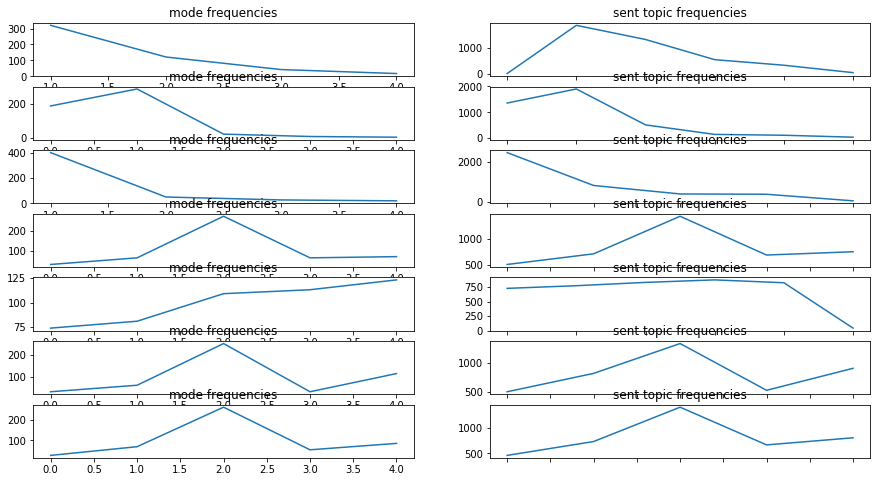

In [78]:
# all topics frequency distribution 
import matplotlib.pyplot as plt

topic_models_list = [i for i in df.columns if i.endswith('_mode')]
topic_models_list.remove('lda_random_projections_topic_mode')
fig, axes = plt.subplots(len(topic_models_list), 2, figsize=(15, 8))

for i, model in enumerate(topic_models_list):
    topic_freqs = df[model].value_counts().sort_index().plot(ax=axes[i, 0], title='mode frequencies')
    pd_topic_frequencies = df[model+'_prob'].apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
    topic_sent_freqs = pd_topic_frequencies.sum().sort_index().plot(ax=axes[i, 1], title='sent topic frequencies')

plt.show()

In [6]:
df.lsi_topic_mode.value_counts()

0.0    17858
4.0      591
1.0      478
2.0       91
3.0        1
Name: lsi_topic_mode, dtype: int64

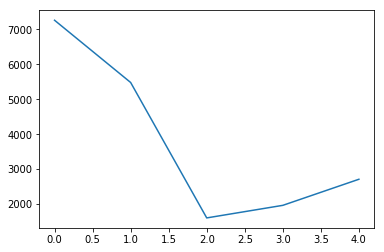

In [32]:
df.lda_topic_mode.value_counts().sort_index().plot()

In [17]:
pd_topic_frequencies = df.lda_topic_mode_prob.apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
pd_topic_frequencies.head()

,1,2,0,4,3
0,4.0,3.0,2.0,2.0,0.0
1,3.0,1.0,0.0,1.0,0.0
2,2.0,1.0,5.0,5.0,1.0
3,7.0,10.0,7.0,5.0,5.0
4,3.0,0.0,4.0,1.0,2.0


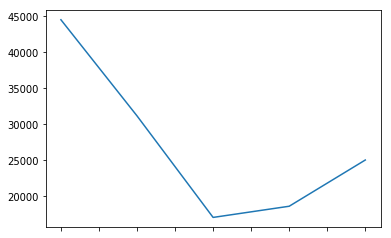

In [33]:
pd_topic_frequencies.sum().sort_index().plot()

## Topics Models

In [45]:
import itertools
import ast
df = pd.read_csv('../../data/processed/yp_competitors_rws_0001_0050_complete.csv')
revs = df.norm_tokens_doc[:1000].apply(lambda x: ast.literal_eval(x))
docs = list(itertools.chain(*revs))

In [52]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

id2word = Dictionary(docs)

lda_model_list = []
coherence_list = []
for num_topics in range(2, 21, 3):
    model_path = f'../../model/lda_model/lda_{num_topics}.model'
    lda_model = LdaModel.load(model_path)
    lda_model_list.append(lda_model)
    
    coherencemodel = CoherenceModel(model=lda_model, corpus=id2word, texts=revs)
    coherence_list.append(coherencemodel)

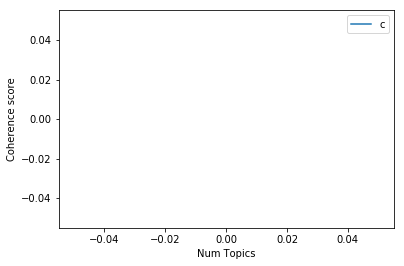

In [50]:
# to select number of topics
import matplotlib.pyplot as plt
x = range(2, 21, 3)
plt.plot(x, coherence_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
coherence_list[0].get_coherence()

/Applications/anaconda3/envs/text/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:193: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/Applications/anaconda3/envs/text/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:194: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/Applications/anaconda3/envs/text/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:189: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


nan